# Data exploration

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import pickle
import copy
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline

### 1. Load dataset

In [3]:
# Load match data as well as few other dictionaries to investigate the result of the cook-off show
# Load to Pandas dataframe
data_path = '../data/'
match_data = pd.read_csv(data_path + 'match_data.csv', 
                         index_col = None,
                         usecols   = ['win_chef', 'lose_chef', 'on_air', 'guest', 'order_in',
                                      'win_recipe', 'lose_recipe', 'match_key'])

In [4]:
cast_data = pd.read_csv(data_path + 'cast_data.csv', 
                         index_col = None,
                         usecols   = ['castname', 'idx', 'age', 
                                      'gender', 'class'])
cast_data.columns = ['castname', 'cast_idx', 'cast_age', 'cast_gender', 'cast_class']

### 2. Analyze number of cook-offs against winning rate

In [5]:
# Prepare how many times a given chef cooked
chef_2_cook_num_dict = dict(Counter(list(match_data.win_chef) + list(match_data.lose_chef)))

# Prepare how many times a given chef won
chef_win_number_dict  = dict(Counter(list(match_data.win_chef)))

# Calculate winning rate
chef_2_win_rate_list  = []
chef_list, num_cook   = [], []
for chef in list(chef_2_cook_num_dict.keys()):
    chef_list.append(chef)
    num_cook.append(chef_2_cook_num_dict[chef])
    chef_2_win_rate_list.append(chef_win_number_dict.get(chef, 0) / chef_2_cook_num_dict[chef])

#### Plot as a bar graph with line graph to indicate win-ate

In [38]:
# Declare other variable names
chef_name_list = [cast_data.loc[cast_data['cast_idx'] == chef].values[0][0] for chef in chef_list]

num_cook_win_df = pd.DataFrame({
    'num_cook': num_cook,
    'win_rate': chef_2_win_rate_list,
    'chefname': chef_name_list
})

num_cook_win_df["win_rate"] = num_cook_win_df["win_rate"].round(2)
num_cook_win_df = num_cook_win_df.sort_values(by = ['num_cook'], ascending = False).reset_index()

threshold = 20

chef_name_xaxis = num_cook_win_df.chefname.values

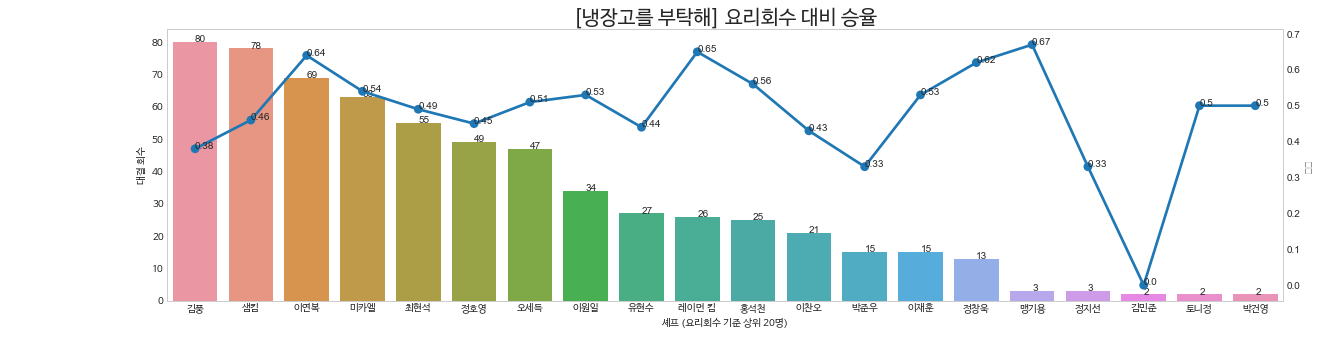

In [44]:
# This is to display Asian fonts. If you need to install Asian font, 
# change the fname path to the correct directory in your computer
font_name = font_manager.FontProperties(fname = '/Users/db91057/Library/Fonts/custom/NanumBarunGothic.ttf').get_name()
rc('font', family = font_name)

fig, ax = plt.subplots(figsize = (20,5))

sns.set_style("whitegrid")
ax = sns.barplot(x = chef_name_xaxis[:threshold] , y = num_cook_win_df.num_cook[:threshold])
ax.grid(False)

ax.set_xlabel("셰프 (요리회수 기준 상위 {}명)".format(threshold))
ax.set_xticklabels(chef_name_xaxis[:threshold])
ax.set_ylabel('대결 회수')

ax2 = ax.twinx()
ax2 = sns.pointplot(x = chef_name_xaxis[:threshold] , y = num_cook_win_df.win_rate[:threshold])
ax2.set_ylabel("승율")
ax2.grid(False)

for i,j in num_cook_win_df.num_cook.items():
    ax.annotate(str(j), xy=(i, j))

for i,j in num_cook_win_df[:threshold].win_rate.items():
    ax2.annotate(str(j), xy=(i, j))
    
ax.set_title("[냉장고를 부탁해] 요리회수 대비 승율",fontsize=20)

plt.show()

fig.savefig("../data/nbh_apperance_winning_rate.png")

### 3. Calculate the strongest and weakest opponent
* Given chef A and B, calculate the likelihood of each winning the next match based on the two's history

In [168]:
# Create a matrix to update match scores
# We want to add +1 to every match won
match_pair = match_data[['win_chef', 'lose_chef']].values.tolist()

num_chef = len(cast_data.loc[cast_data['cast_class'] == 'chef'])
score_matrix_zeros = np.zeros([num_chef, num_chef])

In [169]:
def update_score(matrix, match_pair):
    """
    Add +1 to every match won
    Output: Updated matrix
    """
    for pair in match_pair:
        matrix[pair[0], pair[1]] += 1
        
    return matrix

In [170]:
score_matrix = update_score(score_matrix_zeros, match_pair)

In [171]:
# Now we want to count every cook-off number bewteen each component
sorted_match_pair = []
for pair in match_pair:
    sorted_pair = tuple(sorted(pair))
    sorted_match_pair.append(sorted_pair)
    
# Use counter to count how many match occured per chef (A,B)
match_pair_count = Counter(sorted_match_pair)
match_pair_count_dict = dict(match_pair_count)

In [172]:
# Update total_match counts
# Create empty matrix
total_match_matrix = np.zeros([num_chef, num_chef])
for pair in match_pair_count_dict.keys():
    chef_a = pair[0]
    chef_b = pair[1]
    total_match_matrix[chef_a, chef_b] += match_pair_count_dict[pair]
    total_match_matrix[chef_b, chef_a] += match_pair_count_dict[pair]

In [173]:
# Now we will devide the score matrix with total match matrix to get win rate
# win num / total match cnt = win rate

win_rate_matrix = np.divide(score_matrix, total_match_matrix, out = np.zeros_like(score_matrix), where = total_match_matrix != 0)

In [204]:
# Define matrix labels
chef_only_df = cast_data.loc[cast_data['cast_class'] =='chef'].sort_values(by = ['cast_idx']).reset_index()
chef_names   = chef_only_df.castname.values.tolist()

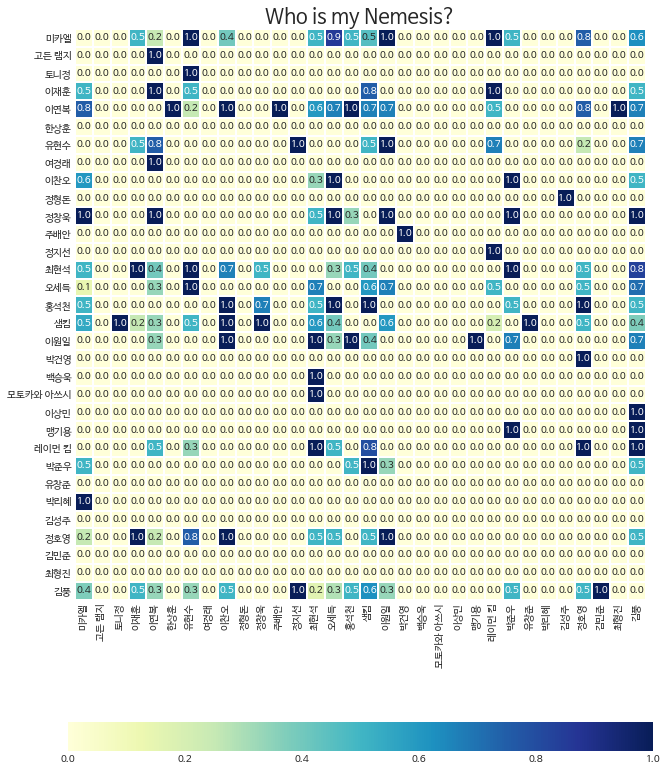

In [205]:
font_name = font_manager.FontProperties(fname = '/Users/db91057/Library/Fonts/custom/NanumBarunGothic.ttf').get_name()
rc('font', family = font_name)

fig, ax = plt.subplots(figsize = (15,15))

ax = sns.heatmap(win_rate_matrix, 
                 annot=True, 
                 fmt=".1f", 
                 linewidths=1.0, 
                 square=1,
                 xticklabels=chef_names,
                 yticklabels=chef_names,
                 cmap="YlGnBu",
                cbar_kws = {"orientation":"horizontal","shrink": .70})
plt.title('Who is my Nemesis?',fontsize=20)

fig.savefig("../data/nbh_nemesis.png")